In [1]:
# Download NEURON: http://www.neuron.yale.edu/neuron/download
# Download PyNeuronToolbox: https://github.com/ahwillia/PyNeuron-Toolbox

from neuron import h
import numpy as np
import pylab as plt
from PyNeuronToolbox.record import ez_record,ez_convert
from PyNeuronToolbox.synapses import add_exp2
import time
%matplotlib inline
np.random.seed(123456789)

# Load morphology and other stuff
# --> SegLists: soma[2], dend[74], dend_5[37], apic[42], axon[1]
# --> Files from Migliore & Migliore (2012)
# --> CA1 pyramidal neuron
h.load_file('stdrun.hoc')
h.xopen('ri06.hoc')
h.xopen('fixnseg.hoc')
h.xopen('5a_nogui.hoc')

## Get a list of segments
from PyNeuronToolbox.morphology import dist_between,allsec_preorder

def dist_to_soma(segment):
    return dist_between(h,h.soma[0](0.5),segment)

#seglist in pre-order
sec_list = allsec_preorder(h)
seg_list = []
for sec in sec_list:
    locs = np.linspace(0,1,sec.nseg+2)[1:-1]
    for loc in locs:
        seg_list.append(sec(loc))
n = len(seg_list)

In [2]:
def sushi_system(a,b,c):
    """
    Returns a matrix A, such that dx/dt = A*x
    
    N = # of compartments
    A is (2N x 2N) matrix
    x is (2N x 1) vector.
      The first N elements correspond to concentrations of u (molecules in transit)
      The second half correspond to concentrations of u-star (detached/active molecules)
    The trafficking rate constants along the microtubules are given by the vectors "a" and "b"
    The rate constants for u detaching/attaching (turning into u*) are given by "c" and "d"
    """
    # number of compartments
    N = len(d)
    
    ## State-space equations
    #  dx/dt = Ax + Bu
    A = np.zeros((2*N,2*N))

    # Trafficking along belt
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            # Out of parent, into child
            ai = a.pop()
            A[p,p] += -ai
            A[i,p] += ai
            # Into parent, out of child
            bi = b.pop()
            A[p,i] += bi
            A[i,i] += -bi
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                # Out of parent, into child
                ai = a.pop()
                A[i-1,i-1] += -ai
                A[i,i-1] += ai
                # Into parent, out of child
                bi = b.pop()
                A[i-1,i] += bi
                A[i,i] += -bi
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # Detachment off the belt
    for i in range(N):
        A[i,i] += -c[i]
        A[i+N,i] += c[i]
    
    return A

In [3]:
def trafficking_solution(utarg):
    """ Solve the problem by tuning trafficking rates, like Figs 1 and 2. """
    x = []
    
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            mp = utarg[p] # concentration in parent
            mc = utarg[i] # concentration in child
            x.insert(0,mp/mc)
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                mp = utarg[i-1]
                mc = utarg[i]
                x.insert(0,mp/mc)
                
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # return calculated guesses (flip, up/down since get_deriv pops from start)
    return np.array(x)

def get_sys_matrix():
    # F is a mixing factor between 0 and 1
    K = np.sum(utarg)/n
    x = trafficking_solution(F*utarg + (1-F)*K)
    a = list((1/(1+x)))
    b = list((1/(1+x**-1)))
    c = list(1e-5*utarg/(F*utarg + (1-F)*K))
    A = sushi_system(a,b,c)
    return A

In [4]:
from scipy.linalg import expm  # matrix exponential used to solve linear system
from mpl_toolkits.mplot3d import Axes3D
from PyNeuronToolbox.morphology import shapeplot

t0,dt = 2e1,3
def run_sim():
    A = get_sys_matrix()

    # initial condition, u starts only in soma and is trafficked out to dendrites
    u0 = np.zeros(2*n)
    u0[0] = sum(utarg)  # compartment 0 is the soma
    
    u = [np.dot(expm(t0*A),u0)]
    t = [t0]
    while t[-1] < 1e7:
        t.append(t[-1]*dt)
        u.append(np.dot(expm(t[-1]*A),u0))
        
    u = np.array(u)
    print np.sum(u[:,:n],axis=1)
    unorm = u[:,:n]/np.tile(np.sum(u[:,:n],axis=1),(n,1)).T
    K = np.sum(utarg)/n
    err_u = np.linalg.norm((unorm - np.tile(F*utarg + (1-F)*K,(len(t),1))),ord=1,axis=1)
    err_ustar = np.linalg.norm((u[:,n:] - np.tile(utarg,(len(t),1))),ord=1,axis=1)
    
    return u,np.array(t),list(err_u),list(err_ustar)

def snapshot(i,clim=None):
    if clim is None: clim = [0,max(u[i,n:])]
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,cvals=u[i,n:],clim=clim,\
                      cmap=plt.cm.cool,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('t = '+str(t[-1]),fontweight='bold',fontsize=14)

    # colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    sm._A = []
    plt.colorbar(sm, shrink=0.5)
    plt.tight_layout()
    plt.axis('off')

[  9.99800020e-01   9.99400180e-01   9.98201619e-01   9.94614554e-01
   9.83930514e-01   9.52562078e-01   8.64330552e-01   6.45713095e-01
   2.69227105e-01   1.95144512e-02   7.43137244e-06   4.10399745e-16
   6.91227882e-47]


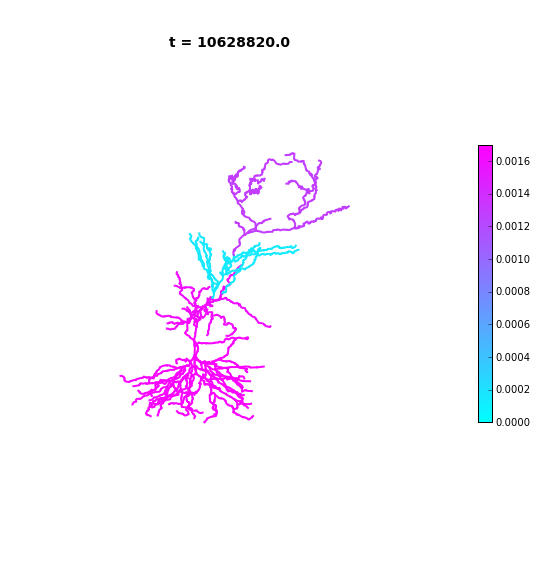

In [5]:
sim_data = {'t':[],'err_u':[],'err_ustar':[],'u':[],'label':[]}

# Define bottleneck target distribution
utarg = np.ones(len(seg_list))
utarg[140:260] = 0.1
utarg /= np.sum(utarg)

# Simulate, use microtubule transport strategy (F=1)
F = 1.0

# Simulate
u,t,err_u,err_ustar = run_sim()
sim_data['t'].append(t)
sim_data['u'].append(u)
sim_data['err_u'].append(err_u)
sim_data['err_ustar'].append(err_ustar)
sim_data['label'].append('bottleneck_microtubule')
snapshot(-1)
plt.savefig('bottleneck_ss.svg')

In [6]:
# Define bottleneck target distribution
utarg = np.ones(len(seg_list))
utarg[140:260] = 0.1
utarg /= np.sum(utarg)

# Simulate, use local release strategy (F=0)
F = 0.0

# Simulate
u,t,err_u,err_ustar = run_sim()
sim_data['t'].append(t)
sim_data['u'].append(u)
sim_data['err_u'].append(err_u)
sim_data['err_ustar'].append(err_ustar)
sim_data['label'].append('bottleneck_local_release')

[  9.99765962e-01   9.99298347e-01   9.97902049e-01   9.93776160e-01
   9.81853795e-01   9.48480566e-01   8.58869409e-01   6.41697063e-01
   2.68063476e-01   1.95418509e-02   7.57094081e-06   4.40252992e-16
   8.65684640e-47]


In [7]:
# Define bottleneck target distribution
utarg = np.ones(len(seg_list))
utarg[140:260] = 0.1
utarg /= np.sum(utarg)

# Simulate, use interpolated strategy (F=0.5)
F = 0.5

# Simulate
u,t,err_u,err_ustar = run_sim()
sim_data['t'].append(t)
sim_data['u'].append(u)
sim_data['err_u'].append(err_u)
sim_data['err_ustar'].append(err_ustar)
sim_data['label'].append('bottleneck_interp')

[  9.99784328e-01   9.99353294e-01   9.98064339e-01   9.94236632e-01
   9.83027052e-01   9.50841876e-01   8.61946342e-01   6.43826273e-01
   2.68580735e-01   1.94984928e-02   7.46070034e-06   4.17941271e-16
   7.34720645e-47]


[  9.99800020e-01   9.99400180e-01   9.98201619e-01   9.94614554e-01
   9.83930514e-01   9.52562078e-01   8.64330552e-01   6.45713095e-01
   2.69227105e-01   1.95144512e-02   7.43137244e-06   4.10399745e-16
   6.91227881e-47]


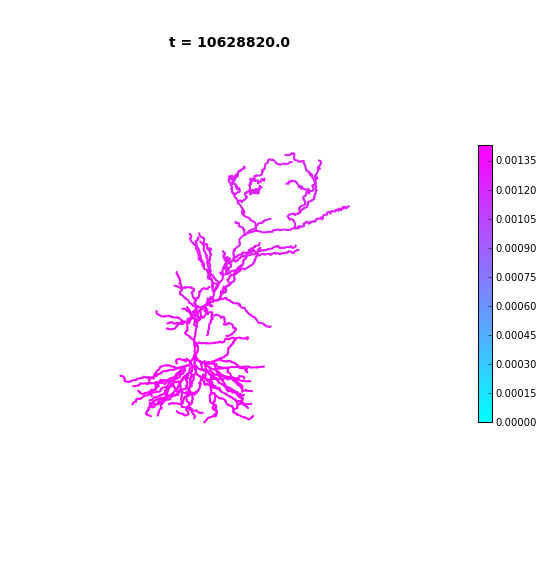

In [8]:
# Define uniform target distribution
utarg = np.ones(len(seg_list))
utarg /= np.sum(utarg)

# Simulate, use microtubule transport strategy (F=1)
F = 1.0

# Simulate
u,t,err_u,err_ustar = run_sim()
sim_data['t'].append(t)
sim_data['u'].append(u)
sim_data['err_u'].append(err_u)
sim_data['err_ustar'].append(err_ustar)
sim_data['label'].append('uniform_microtubule')
snapshot(-1)
plt.savefig('uniform_ss.svg')

In [9]:
# Define uniform target distribution
utarg = np.ones(len(seg_list))
utarg /= np.sum(utarg)

# Simulate, use microtubule transport strategy (F=0)
F = 0.0

# Simulate
u,t,err_u,err_ustar = run_sim()
sim_data['t'].append(t)
sim_data['u'].append(u)
sim_data['err_u'].append(err_u)
sim_data['err_ustar'].append(err_ustar)
sim_data['label'].append('uniform_local_release')

[  9.99800020e-01   9.99400180e-01   9.98201619e-01   9.94614554e-01
   9.83930514e-01   9.52562078e-01   8.64330552e-01   6.45713095e-01
   2.69227105e-01   1.95144512e-02   7.43137244e-06   4.10399745e-16
   6.91227881e-47]


In [10]:
# Define uniform target distribution
utarg = np.ones(len(seg_list))
utarg /= np.sum(utarg)

# Simulate, use microtubule transport strategy (F=0.5)
F = 0.5

# Simulate
u,t,err_u,err_ustar = run_sim()
sim_data['t'].append(t)
sim_data['u'].append(u)
sim_data['err_u'].append(err_u)
sim_data['err_ustar'].append(err_ustar)
sim_data['label'].append('uniform_interp')

[  9.99800020e-01   9.99400180e-01   9.98201619e-01   9.94614554e-01
   9.83930514e-01   9.52562078e-01   8.64330552e-01   6.45713095e-01
   2.69227105e-01   1.95144512e-02   7.43137244e-06   4.10399745e-16
   6.91227881e-47]


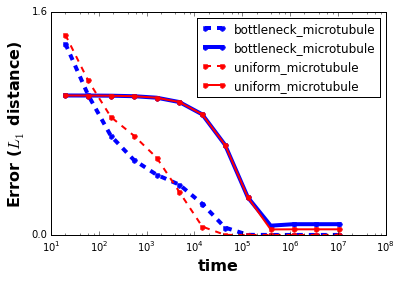

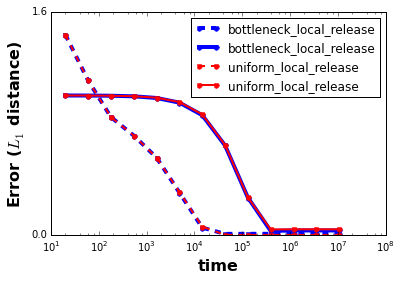

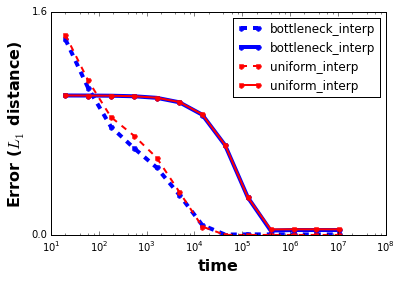

In [22]:
for s in range(0,3):
    plt.figure()
    ax = plt.subplot(111)
    plt.plot(sim_data['t'][s],sim_data['err_u'][s],'.--',label=sim_data['label'][s],markersize=10,lw=4,color="b")
    plt.plot(sim_data['t'][s],sim_data['err_ustar'][s],'.-',label=sim_data['label'][s],markersize=10,lw=4,color="b")
    plt.plot(sim_data['t'][s+3],sim_data['err_u'][s+3],'.--',label=sim_data['label'][s+3],markersize=10,lw=2,color="r")
    plt.plot(sim_data['t'][s+3],sim_data['err_ustar'][s+3],'.-',label=sim_data['label'][s+3],markersize=10,lw=2,color="r")
    #plt.ylim([0,0.7])
    #plt.xlim([t0,t[-1]])
    plt.xscale("log")
    plt.ylabel('Error ($L_1$ distance)',fontweight='bold',fontsize=16)
    plt.xlabel('time',fontweight='bold',fontsize=16)
    #plt.xlim([0,6e4])
    #plt.xticks([20000,40000,60000])
    plt.yticks([0,1.6])
    plt.legend()
    plt.savefig('panel_D'+str(s)+'.svg')
    plt.show()
plt.show()